# Hotel Booking Cancellation Prediction

![Hotel Look](https://images.app.goo.gl/e6bk3W6bUqN9Yas46)

## Overview

This project focuses on creating a predictive model to anticipate hotel booking cancellations using historical data. The model will be trained on a [dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset) sourced from Kaggle, which includes a vast collection of customer hotel reservations. The main goal is to design a machine learning system capable of reliably estimating the probability of a booking being canceled. Such predictions can assist hotels in optimizing inventory control, staff allocation, and revenue management.

The process will include data preprocessing, exploratory analysis, feature engineering, model development, and performance assessment. Key evaluation metrics like accuracy, precision, recall, and F1-score will be used to gauge the model’s effectiveness.

Additionally, the study will examine how different factors influence cancellations, uncovering patterns and opportunities for enhancement. Ultimately, this initiative offers significant benefits to the hospitality sector by enabling data-driven decisions. With an accurate cancellation forecast, hotels can allocate resources more efficiently, enhance guest experiences, and boost profitability.

## Business Understanding

The hospitality industry faces significant revenue losses due to booking cancellations, which average 40% of reservations. To address this, a predictive model can help hotels forecast cancellations and take proactive measures—such as targeted discounts or optimized staffing—to minimize losses. By analyzing historical data, the model enables better inventory management and revenue strategies. This project provides business value by improving occupancy rates, enhancing customer satisfaction, and reducing financial risks. With accurate predictions, hotels can gain a competitive edge, ensuring efficient resource allocation and higher profitability. Ultimately, the model empowers hotels to make data-driven decisions, transforming cancellation challenges into opportunities for growth.

## Data Understanding

To achieve this objective, I have utilized the Hotel Reservations [Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset) obtained from Kaggle. The dataset contains information about hotel bookings made by customers, including various features such as the number of adults and children, the type of meal plan, the requirement for a car parking space, the type of room reserved, the lead time, the arrival date, the market segment type, and whether the booking was cancelled or not.

The dataset consists of 36,275 rows and 19 columns, with each row representing a unique booking. The target variable will be the `booking_status` column, which indicates whether the booking was cancelled (1) or not (0).

The dataset includes the following features:
- Booking_ID: unique identifier of each booking
- no_of_adults: Number of adults
- no_of_children: Number of Children
- no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- type_of_meal_plan: Type of meal plan booked by the customer:
- required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
- room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- lead_time: Number of days between the date of booking and the arrival date
- arrival_year: Year of arrival date
- arrival_month: Month of arrival date
- arrival_date: Date of the month
- market_segment_type: Market segment designation.
- repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
- no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
- no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
- avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
- booking_status: Flag indicating if the booking was canceled or not.

In [9]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="whitegrid")
%matplotlib inline

### Reading the data

In [11]:
# Load data
df = pd.read_csv('Hotel-Reservations.csv')
df.head(2)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled


### Cleaning the data
1. Check data types and figure out which figures are numerical and which are categorical.
2. Check for null values.
3. Check for duplicate values
4. Remove unnecessary columns and missing values

In [13]:
# Check for any missing values
df.isna().any().any()

False

In [14]:
# Check for duplicates
df.duplicated().sum()

0

In [15]:
# check data types
df.dtypes

Booking_ID                               object
no_of_adults                              int64
no_of_children                            int64
no_of_weekend_nights                      int64
no_of_week_nights                         int64
type_of_meal_plan                        object
required_car_parking_space                int64
room_type_reserved                       object
lead_time                                 int64
arrival_year                              int64
arrival_month                             int64
arrival_date                              int64
market_segment_type                      object
repeated_guest                            int64
no_of_previous_cancellations              int64
no_of_previous_bookings_not_canceled      int64
avg_price_per_room                      float64
no_of_special_requests                    int64
booking_status                           object
dtype: object

 The `repeated_guest` feature is represented as an integer, with 0 indicating that the customer is not a repeated guest and 1 indicating that the customer is a repeated guest. However, the nature of this feature suggests that it is categorical in nature, as it represents a binary classification of customers based on their booking history. Therefore, it is appropriate to treat this feature as a categorical variable in the analysis and modeling process. This also applies to the `required_car_parking_space` feature, which is also represented as an integer.

### Data Preparation

1. Convert `booking_status` to numeric - I will convert 'Canceled' to 1 and 'Not_Canceled' to 0.

In [19]:
# convert values in the column 'booking_status' to 0 and 1
df['booking_status'] = df['booking_status'].map({'Not_Canceled': 0, 'Canceled': 1})

2. Convert the rest of the categorical features i.e. `type_of_meal_plan`, `market_segment_type`, `room_type_reserved` to numeric values.

In [21]:
# Check the unique values in type_of_meal_plan, market_segment_type, 
# and room_type_reserved
meal_plans = df['type_of_meal_plan'].unique()
market_segments = df['market_segment_type'].unique()
room_types = df['room_type_reserved'].unique()

# Print unique values
print("Unique values in 'type_of_meal_plan' column:")
print(meal_plans)
print("\nUnique values in 'market_segment_type' column:")
print(market_segments)
print("\nUnique values in 'room_type_reserved' column:")
print(room_types)

Unique values in 'type_of_meal_plan' column:
['Meal Plan 1' 'Not Selected' 'Meal Plan 2' 'Meal Plan 3']

Unique values in 'market_segment_type' column:
['Offline' 'Online' 'Corporate' 'Aviation' 'Complementary']

Unique values in 'room_type_reserved' column:
['Room_Type 1' 'Room_Type 4' 'Room_Type 2' 'Room_Type 6' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']


Next, convert the categorical features in `type_of_meal_plan`, `market_segment_type`, and `room_type_reserved` to numeric values using `.map()` function because they represent ordinal relationships. 

In [23]:
# Convert values in the type_of_meal_plan to numerical values
df['type_of_meal_plan'] = df['type_of_meal_plan'].map({'Not Selected': 0,
                                                             'Meal Plan 1': 1,
                                                             'Meal Plan 2': 2,
                                                             'Meal Plan 3': 3})

# Convert values in the room_type_reserved to numerical values
df['room_type_reserved'] = df['room_type_reserved'].map({'Room_Type 1': 1,
                                                             'Room_Type 2': 2,
                                                             'Room_Type 3': 3,
                                                             'Room_Type 4': 4,
                                                             'Room_Type 5': 5,
                                                             'Room_Type 6': 6,
                                                             'Room_Type 7': 7})


# Convert values in the market_segment_type to numerical values
df['market_segment_type'] = df['market_segment_type'].map({'Offline': 0,
                                                             'Online': 1,
                                                             'Corporate': 2,
                                                             'Complementary': 3,
                                                             'Aviation': 4})

### Data Transformation

First, split the data into train and test sets using the `train_test_split` function from the `sklearn.model_selection` module. This will allow me to estimate how well the model will perform on unseen data later on.

In [26]:
# split dataset into features and target
X = df.drop(['booking_status', 'Booking_ID'], axis=1)
y = df['booking_status']

In [27]:
# split dataset into train and test sets
# set shuffle to True to randomize the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=28)

Next, use scikit-learn's OneHotEncoder to convert `type_of_meal_plan`, `market_segment_type`, `repeated_guest`, `room_type_reserved`, and `required_car_parking_space` into numerical values.

In [29]:
# Create an instance of OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)

# Create dataframe with only the columns that require One Hot Encoding
categorical_train = X_train[['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 
                          'market_segment_type', 'repeated_guest']].copy()

categorical_test = X_test[['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 
                          'market_segment_type', 'repeated_guest']].copy()

# Fit the encoder on the training data and transform it
ohe.fit_transform(categorical_train)

# Transform the test data
ohe.transform(categorical_test)

# Create new dataframes with One Hot Encoded columns
categorical_train_ohe = pd.DataFrame(data=ohe.transform(categorical_train),
                                    columns=ohe.get_feature_names_out(),
                                    index=categorical_train.index)

categorical_test_ohe = pd.DataFrame(data=ohe.transform(categorical_test),
                                   columns=ohe.get_feature_names_out(),
                                   index=categorical_test.index)

Next scale the data using scikit-learn's `StandardScaler`.

In [31]:
# create an instance of StandardScaler
scaler = StandardScaler()

# Create dataframe with only quantitative variables
quant_train = X_train[['arrival_year', 'arrival_month', 'arrival_date','no_of_adults', 'no_of_children', 
                   'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 
                   'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']].copy()

quant_test = X_test[['arrival_year', 'arrival_month', 'arrival_date','no_of_adults', 'no_of_children', 
                   'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'no_of_previous_cancellations', 
                   'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']].copy()

# Fit and transform the train data
scaler.fit_transform(quant_train)

# Transform the test data
scaler.transform(quant_test)

# Create new dataframes with Scaler columns
quant_train_scaler = pd.DataFrame(data=scaler.transform(quant_train),
                                  columns=quant_train.columns,
                                  index=quant_train.index)

quant_test_scaler = pd.DataFrame(data=scaler.transform(quant_test),
                                  columns=quant_test.columns,
                                  index=quant_test.index)

In [32]:
# Append encoded and scaled columns to X_train_transformed and X_test_transformed
# Append one hot encoded data back to dataframe
X_train_transformed = pd.concat([quant_train_scaler, categorical_train_ohe], axis=1)

X_test_transformed = pd.concat([quant_test_scaler, categorical_test_ohe], axis=1)

# Preview new dataframe
X_train_transformed.head()

,arrival_year,arrival_month,arrival_date,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,lead_time,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,...,room_type_reserved_3,room_type_reserved_4,room_type_reserved_5,room_type_reserved_6,room_type_reserved_7,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,repeated_guest_1
2947,0.46805,-0.136897,-0.642154,0.298216,2.20181,0.218603,-1.550369,-0.991105,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3033,0.46805,-1.758329,1.423318,-1.635357,-0.26098,1.363639,-0.847614,-0.979430,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
30081,0.46805,0.835962,-1.101148,0.298216,4.66460,-0.926433,-0.847614,0.304761,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21861,0.46805,-1.434042,-1.330645,0.298216,-0.26098,1.363639,-0.144860,-0.664220,-0.062816,-0.086268,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11680,0.46805,0.835962,-0.986400,0.298216,-0.26098,-0.926433,-0.144860,-0.827662,-0.062816,-0.086268,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Modeling - Baseline Model

Create a Logistic Regression model using scikit-learn's `LogisticRegression` class. The model will be trained on the `X_train_transformed` and `y_train` data. This baseline model will model the probability of the target variable `booking_status` as a function of the input features, and it can provide insights into the relative importance of each feature in predicting the target.

Here's the criteria I will use to explain the baseline model metrics:

1. Accuracy - The proportion of correct predictions made by the model.
2. Precision - The proportion of true positive predictions out of all the positive predictions made by the model.
3. Recall - The proportion of true positive predictions out of all the actual positive instances. 
4. F1 score - The harmonic mean of precision and recall.
5. ROC AUC score - The area under the ROC curve, which measures the model's ability to distinguish between positive and negative instances.

By evaluating the baseline model using this criteria, we can gain insights into it's performance and identify areas for improvement.

In [36]:
# Fit the logistic regression model using sklearn
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_transformed, y_train)

y_pred_train = logreg.predict(X_train_transformed)
y_pred_test = logreg.predict(X_test_transformed)

# Add a constant to the input features for the intercept
X_train_transformed = sm.add_constant(X_train_transformed)

# Get the coefficients and intercept from the fitted sklearn model
params = np.append(logreg.intercept_, logreg.coef_)

# Calculate the p-values using statsmodels
logit_model = sm.Logit(y_train, X_train_transformed)
result = logit_model.fit(disp=False)

# Print the summary
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                27206
Model:                          Logit   Df Residuals:                    27178
Method:                           MLE   Df Model:                           27
Date:                Sun, 11 May 2025   Pseudo R-squ.:                  0.3300
Time:                        22:29:55   Log-Likelihood:                -11492.
converged:                      False   LL-Null:                       -17153.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -2.0257      0.079    -25.741      0.000      -2.180      -1.871
arrival_year                             0.1654      

C:\Users\ChrisKarta\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


From the printed summary above, we can see that the following features are insignificant in predicting the target variable: `arrival_date`, `no_of_previous_bookings_not_canceled`, `type_of_meal_plan_2`, `type_of_meal_plan_3`, `room_type_reserved_3`, and  `market_segment_type_3`. Therefore, we can remove these features from our model. This will help to simplify the model, reduce multicollinearity, and improve its performance.

Next, we'll evaluate the performance of our logistic regression model on the training set using scikit-learn's `accuracy_score` and `confusion_matrix` functions. We will calculate the accuracy, precision, AUC score, and the confusion matrix.

In [39]:
# Evaluation metrics for train set
# Calculate accuracy 
acc = accuracy_score(y_train,y_pred_train) * 100
print('Accuracy is: {0}'.format(acc))

# Calculate precision 
prec = precision_score(y_train,y_pred_train) * 100
print('\nPrecision is: {0}'.format(prec))

# Calculate recall
recall = recall_score(y_train,y_pred_train) * 100
print('\nRecall is: {0}'.format(recall))

# Calculate F1 score
f1 = f1_score(y_train,y_pred_train) * 100
print('\nF1 score is: {0}'.format(f1))

# Check the AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred_train)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is: {0}'.format(round(roc_auc, 2)))

# Create confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_train = confusion_matrix(y_train, y_pred_train)

cm_train_disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                      display_labels=logreg.classes_)
cm_train_disp.plot(cmap=plt.cm.Blues);

Accuracy is: 80.3977063882967

Precision is: 73.38849592953423

Recall is: 62.21995926680245

F1 score is: 67.34431449390729

AUC is: 0.76

Confusion Matrix
----------------


In [40]:
# Evaluation metrics for test set
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred_test) * 100
print('Accuracy is: {0}'.format(acc))

# Calculate precision 
prec = precision_score(y_test,y_pred_test) * 100
print('\nPrecision is: {0}'.format(prec))

# Calculate recall
recall = recall_score(y_test,y_pred_test) * 100
print('\nRecall is: {0}'.format(recall))

# Calculate F1 score
f1 = f1_score(y_test,y_pred_test) * 100
print('\nF1 score is: {0}'.format(f1))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is: {0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_test = confusion_matrix(y_test, y_pred_test)

cm_test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                      display_labels=logreg.classes_)
cm_test_disp.plot(cmap=plt.cm.Purples);

Accuracy is: 80.41680449884221

Precision is: 74.73725184896847

Recall is: 63.012799474893335

F1 score is: 68.37606837606837

AUC is: 0.76

Confusion Matrix
----------------


The results for both the train and test sets are quite similar, which is generally a good sign as it suggests that the model is not overfitting or underfitting. 

- Accuracy: The accuracy values(`80.39%` and `80.42%`) for both the train and test sets are very close, which indicates that the model is performing consistently across different datasets.
- Precision: Precision measures how many of the positive predictions were actually correct. The test set shows slightly better precision of `74.74%` as compared to the train set of `73.38%`, which is a positive sign. However, there is still some room for improvement.
- AUC: Both the train and test sets have the same AUC of `0.76`, which suggests that the model has a reasonable ability to distinguish between the classes, but it's not exceptionally strong.

Overall, I’m moderately satisfied with these results. The model shows consistency between the train and test sets, which is encouraging. However, the performance metrics indicate that there is room for improvement, particularly in precision and AUC.

To further tune the model, I'll be dropping less significant features to improve model performance.

In [43]:
# Drop non-significant features
X_train_transformed = X_train_transformed.drop(['const', 'arrival_date', 'no_of_previous_bookings_not_canceled', 'type_of_meal_plan_2', 
                                               'type_of_meal_plan_3', 'room_type_reserved_3', 'market_segment_type_3'], axis=1)

X_test_transformed = X_test_transformed.drop(['arrival_date', 'no_of_previous_bookings_not_canceled', 'type_of_meal_plan_2', 
                                               'type_of_meal_plan_3', 'room_type_reserved_3', 'market_segment_type_3'], axis=1)

## Hyperparameter Tuning

### Decision Tree Classifier
For the Decision Tree Classifier, I'll be experimenting with different hyperparameters, such as the maximum depth of the tree, and the minimum samples required to split an internal node. By systematically varying these parameters, I aim to improve the model’s accuracy, precision, and overall effectiveness in classifying data. This process will help ensure that the model generalizes well and performs optimally on unseen data.

In [46]:
# Instantiate the decision tree
classifier = DecisionTreeClassifier(criterion='entropy', random_state=28)
classifier.fit(X_train_transformed, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=28)

In [47]:
# Make predictions for train data
y_pred_train = classifier.predict(X_train_transformed)

# Make predictions for test data
y_pred_test = classifier.predict(X_test_transformed)

Next, evaluate the performance of the trained decision tree classifier on the training and test data. Here's the metrics I will use to evaluate the model: Accuracy, Precision, AUC and printing the confusion matrix.

In [49]:
# Evaluate for train set
# Calculate accuracy 
acc = accuracy_score(y_train,y_pred_train) * 100
print('Accuracy is :{0}'.format(acc))

# Calculate precision 
prec = precision_score(y_train,y_pred_train) * 100
print('\nPrecision is :{0}'.format(prec))

# Calculate recall
recall = recall_score(y_train,y_pred_train) * 100
print('\nRecall is :{0}'.format(recall))

# Calculate F1 score
f1 = f1_score(y_train,y_pred_train) * 100
print('\nF1 score is :{0}'.format(f1))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred_train)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_train = confusion_matrix(y_train, y_pred_train)

cm_train_disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                      display_labels=classifier.classes_)
cm_train_disp.plot(cmap=plt.cm.Greens);

Accuracy is :99.33838123943248

Precision is :99.50823421774932

Recall is :98.44987553745192

F1 score is :98.97622568536003

AUC is :0.99

Confusion Matrix
----------------


In [50]:
# Evaluate for test set
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred_test) * 100
print('Accuracy is: {0}'.format(acc))

# Calculate precision 
prec = precision_score(y_test,y_pred_test) * 100
print('\nPrecision is: {0}'.format(prec))

# Calculate recall
recall = recall_score(y_test,y_pred_test) * 100
print('\nRecall is: {0}'.format(recall))

# Calculate f1 score
f1 = f1_score(y_test,y_pred_test) * 100 
print('\nF1 score is: {0}'.format(f1))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is: {0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm_test = confusion_matrix(y_test, y_pred_test)

cm_test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                      display_labels=classifier.classes_)
cm_test_disp.plot(cmap=plt.cm.Blues);

Accuracy is: 87.16506781343037

Precision is: 81.35198135198135

Recall is: 80.17722349852315

F1 score is: 80.7603305785124

AUC is: 0.85

Confusion Matrix
----------------


The metrics printed above indicate that the decision tree classifier performed exceptionally well on the training set, with an **accuracy of 99.34%**, a **precision of 99.51%**, and an **AUC of 0.99**. This suggests that the model is almost perfectly predicting the training data. However, on the test set, the performance drops, with an **accuracy of 87.17%**, a **precision of 81.35%**, and an **AUC of 0.85**. This discrepancy suggests that the model may be overfitting the training data, meaning it has learned to model the training data too well and is not generalizing effectively to unseen data.

I need to boost the precision score since 81% isn’t quite where we want it to be. Our goal is to accurately predict room cancellations so the hotel can manage overselling without risking a lack of space for guests.

In this context, it’s better to have false negatives than false positives. A false positive would mean predicting a guest will cancel when they actually show up, leading to overbooking and potential issues. Conversely, a false negative would involve predicting a guest will keep their reservation, but they end up canceling. Avoiding false positives is crucial to prevent the hotel from overselling and facing a shortage of rooms.

Here are the next steps I'll take o try to improve the performance of the decision tree: 

- Maximum Depth: To reduce overfitting, I’ll limit the tree’s depth. Testing shows that a max depth of 7 provides a good balance, improving precision while keeping accuracy and AUC stable.
- Minimum Samples for Split: Requiring a minimum number of samples to split a node doesn’t improve the model’s performance, so I’ll skip this parameter in the final model.
- Minimum Samples per Leaf: Setting a minimum number of samples for leaf nodes doesn’t enhance the model either, so I’ll exclude it.
- Maximum Features: Limiting the number of features considered during splits also doesn’t add value, so this parameter won’t be included in the final version.

In [53]:
# Identify the optimal tree depth for the train data
acc_train = []
prec_train = []
aucs_train = []

for i in range(1, 31):
    classifier = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)

In [54]:
# Identify the optimal tree depth for the test data
acc = []
prec = []
aucs = []

for i in range(1, 31):
    classifier = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

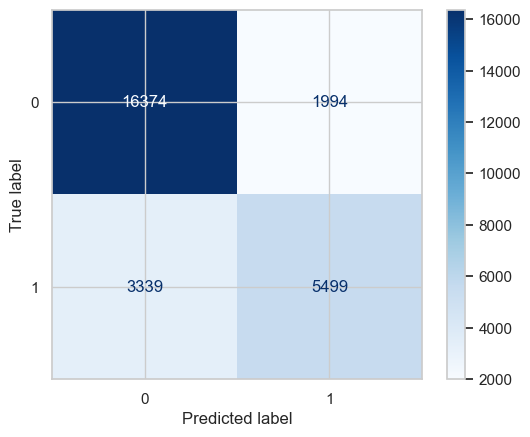

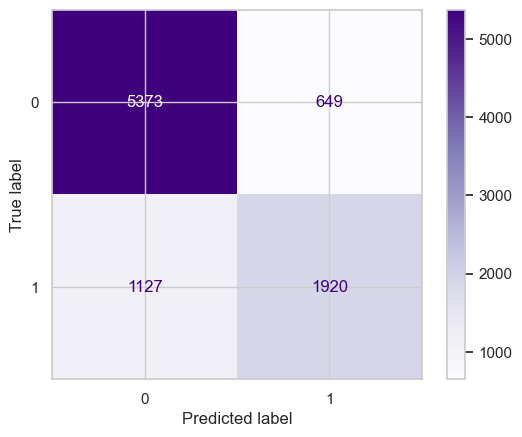

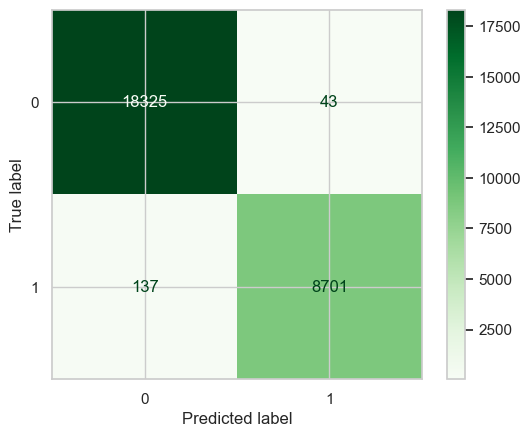

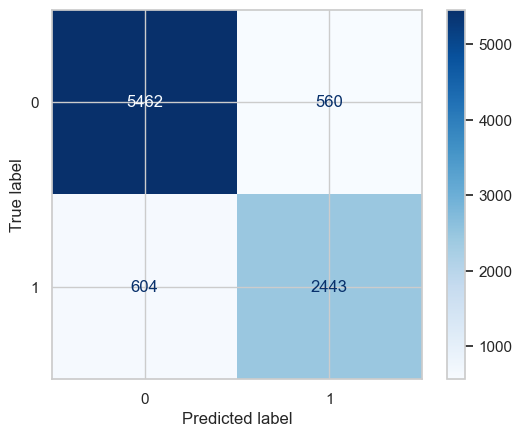

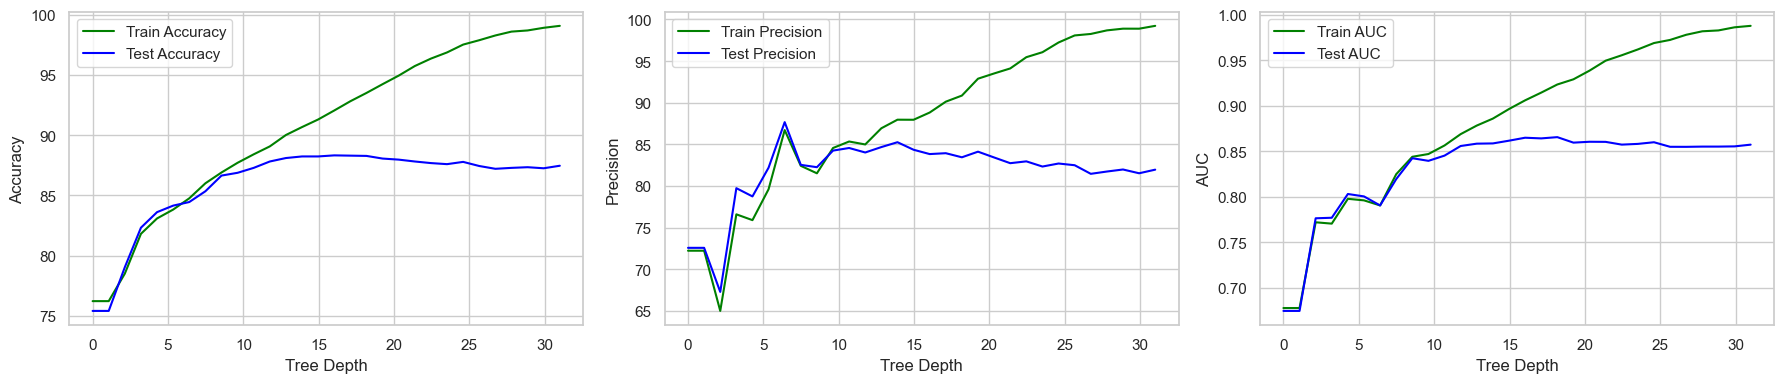

In [55]:
# Create a figure with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# Plot accuracy for train and test data
ax[0].plot(np.linspace(0, 31, 30), acc_train, label='Train Accuracy', c='green')
ax[0].plot(np.linspace(0, 31, 30), acc, label='Test Accuracy', c='blue')
ax[0].set_xlabel('Tree Depth')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot precision for train and test data 
ax[1].plot(np.linspace(0, 31, 30), prec_train, label='Train Precision', c='green')
ax[1].plot(np.linspace(0, 31, 30), prec, label='Test Precision', c='blue')
ax[1].set_xlabel('Tree Depth')
ax[1].set_ylabel('Precision')
ax[1].legend()

# Plot AUC for train and test data
ax[2].plot(np.linspace(0, 31, 30), aucs_train, label='Train AUC', c='green')
ax[2].plot(np.linspace(0, 31, 30), aucs, label='Test AUC', c='blue')
ax[2].set_xlabel('Tree Depth')
ax[2].set_ylabel('AUC')
ax[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [56]:
# Identify the optimal minimum samples split for the train data
acc_train = []
prec_train = []
aucs_train = []

for i in range(2, 11):
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_split=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)

In [57]:
# Identify the optimal minimum samples split for the test data
acc = []
prec = []
aucs = []

for i in range(2, 11):
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_split=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

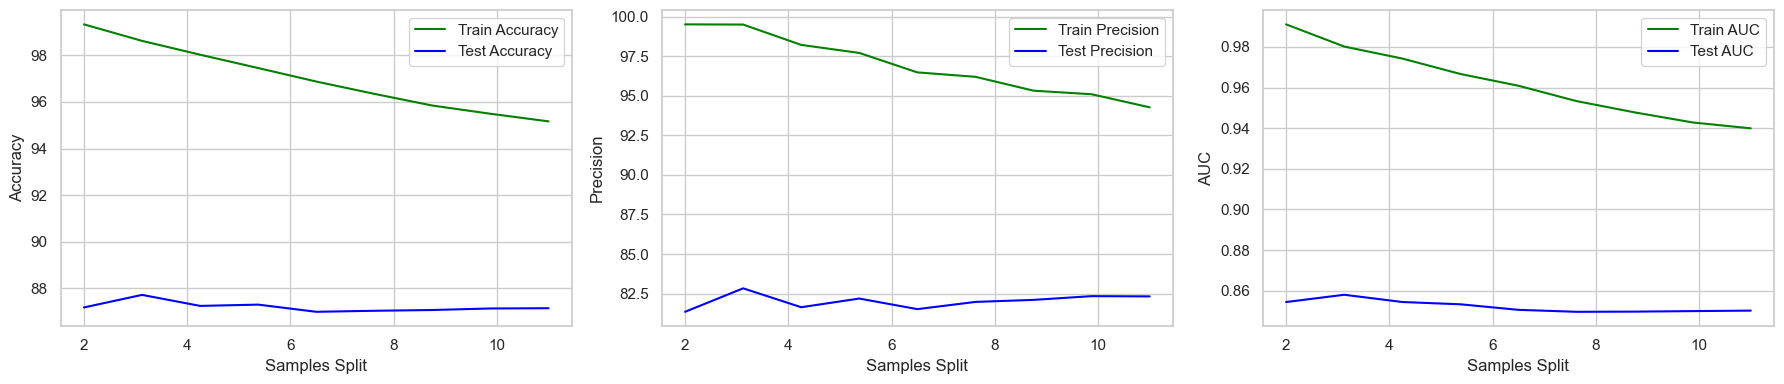

In [58]:
# Create a figure with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# Plot accuracy for train and test data 
ax[0].plot(np.linspace(2,11,9), acc_train, label='Train Accuracy', c='green')
ax[0].plot(np.linspace(2,11,9), acc, label='Test Accuracy', c='blue')
ax[0].set_xlabel('Samples Split')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot precision for train and test data 
ax[1].plot(np.linspace(2,11,9), prec_train, label='Train Precision', c='green')
ax[1].plot(np.linspace(2,11,9), prec, label='Test Precision', c='blue')
ax[1].set_xlabel('Samples Split')
ax[1].set_ylabel('Precision')
ax[1].legend()

# Plot AUC for train and test data 
ax[2].plot(np.linspace(2,11,9), aucs_train, label='Train AUC', c='green')
ax[2].plot(np.linspace(2,11,9), aucs, label='Test AUC', c='blue')
ax[2].set_xlabel('Samples Split')
ax[2].set_ylabel('AUC')
ax[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [59]:
min_samples_splits = np.arange(0.01, 1.0, step=0.1)

# Identify the optimal minimum samples split for the train data
acc_train = []
prec_train = []
aucs_train = []

for min_samples_split in min_samples_splits:
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)

In [60]:
# Identify the optimal minimum samples split for the test data
acc = []
prec = []
aucs = []

for min_samples_split in min_samples_splits:
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

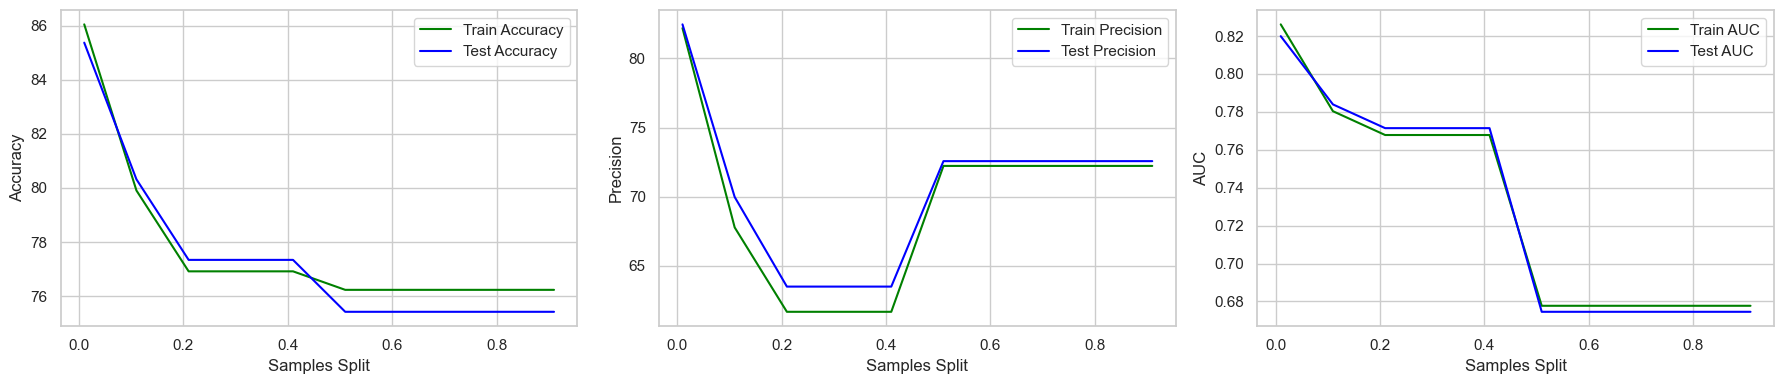

In [61]:
# Create a figure with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# Plot accuracy for train and test data 
ax[0].plot(min_samples_splits, acc_train, label='Train Accuracy', c='green')
ax[0].plot(min_samples_splits, acc, label='Test Accuracy', c='blue')
ax[0].set_xlabel('Samples Split')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot precision for train and test data 
ax[1].plot(min_samples_splits, prec_train, label='Train Precision', c='green')
ax[1].plot(min_samples_splits, prec, label='Test Precision', c='blue')
ax[1].set_xlabel('Samples Split')
ax[1].set_ylabel('Precision')
ax[1].legend()

# Plot AUC for train and test data 
ax[2].plot(min_samples_splits, aucs_train, label='Train AUC', c='green')
ax[2].plot(min_samples_splits, aucs, label='Test AUC', c='blue')
ax[2].set_xlabel('Samples Split')
ax[2].set_ylabel('AUC')
ax[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [62]:
# Identify the optimal minimum samples leaf for the train data
acc_train = []
prec_train = []
aucs_train = []

for i in range(2, 30):
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)

In [63]:
# Identify the optimal minimum samples leaf for the test data
acc = []
prec = []
aucs = []

for i in range(2, 30):
    classifier = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

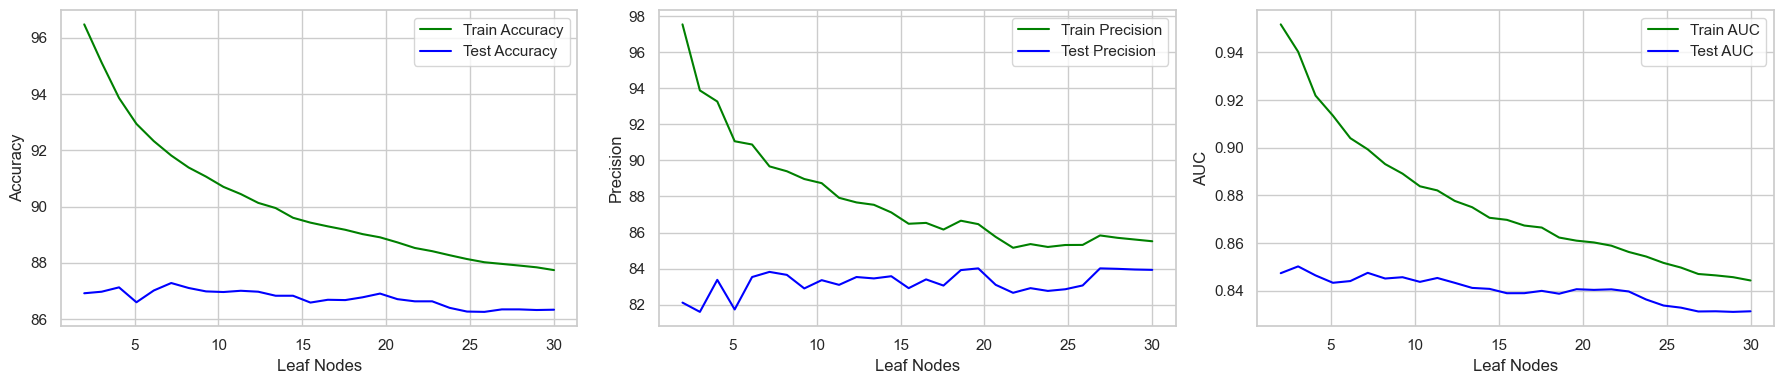

In [64]:
# Create a figure with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# Plot accuracy for train and test data 
ax[0].plot(np.linspace(2, 30, 28), acc_train, label='Train Accuracy', c='green')
ax[0].plot(np.linspace(2, 30, 28), acc, label='Test Accuracy', c='blue')
ax[0].set_xlabel('Leaf Nodes')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot precision for train and test data 
ax[1].plot(np.linspace(2, 30, 28), prec_train, label='Train Precision', c='green')
ax[1].plot(np.linspace(2, 30, 28), prec, label='Test Precision', c='blue')
ax[1].set_xlabel('Leaf Nodes')
ax[1].set_ylabel('Precision')
ax[1].legend()

# Plot AUC for train and test data
ax[2].plot(np.linspace(2, 30, 28), aucs_train, label='Train AUC', c='green')
ax[2].plot(np.linspace(2, 30, 28), aucs, label='Test AUC', c='blue')
ax[2].set_xlabel('Leaf Nodes')
ax[2].set_ylabel('AUC')
ax[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [65]:
# Identify the optimal maximum features for the train data
acc_train = []
prec_train = []
aucs_train = []

for i in range(1, 30):
    classifier = DecisionTreeClassifier(criterion='entropy', max_features=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_train = classifier.predict(X_train_transformed)
    
    acc_score = accuracy_score(y_train,y_pred_train) * 100
    
    prec_score = precision_score(y_train,y_pred_train) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train,y_pred_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc_train.append(acc_score)
    prec_train.append(prec_score)
    aucs_train.append(roc_auc)

In [66]:
# Identify the optimal maximum features for the test data
acc = []
prec = []
aucs = []

for i in range(1, 30):
    classifier = DecisionTreeClassifier(criterion='entropy', max_features=i, random_state=28)
    classifier.fit(X_train_transformed, y_train)
    y_pred_test = classifier.predict(X_test_transformed)
    
    acc_score = accuracy_score(y_test,y_pred_test) * 100
    
    prec_score = precision_score(y_test,y_pred_test) * 100
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    acc.append(acc_score)
    prec.append(prec_score)
    aucs.append(roc_auc)

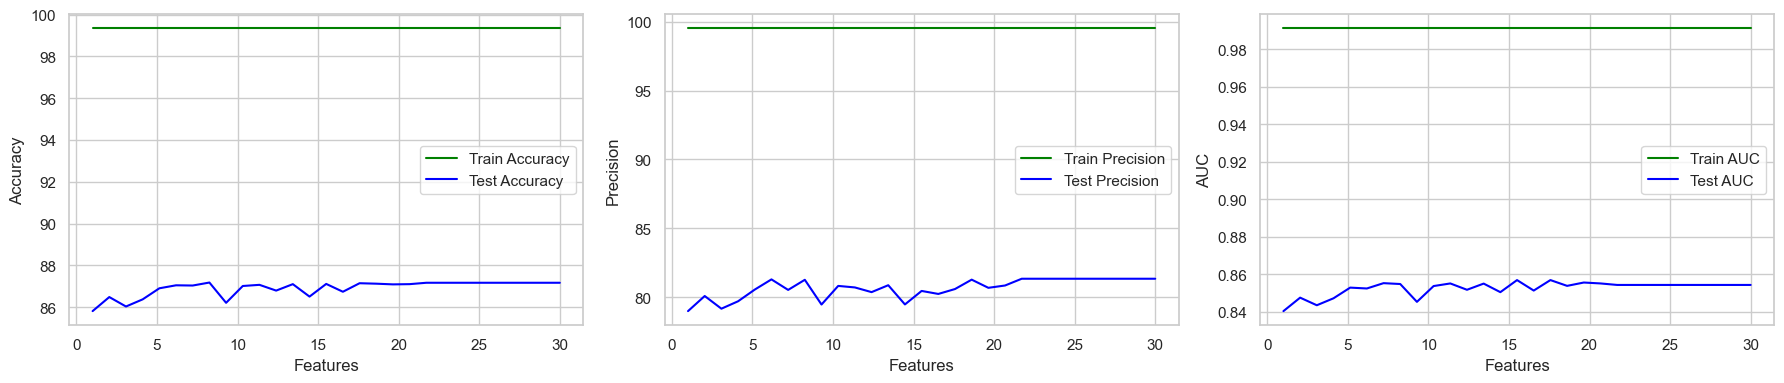

In [67]:
# Create a figure with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# Plot accuracy for train and test data
ax[0].plot(np.linspace(1, 30, 29), acc_train, label='Train Accuracy', c='green')
ax[0].plot(np.linspace(1, 30, 29), acc, label='Test Accuracy', c='blue')
ax[0].set_xlabel('Features')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot precision for train and test data 
ax[1].plot(np.linspace(1, 30, 29), prec_train, label='Train Precision', c='green')
ax[1].plot(np.linspace(1, 30, 29), prec, label='Test Precision', c='blue')
ax[1].set_xlabel('Features')
ax[1].set_ylabel('Precision')
ax[1].legend()

# Plot AUC for train and test data
ax[2].plot(np.linspace(1, 30, 29), aucs_train, label='Train AUC', c='green')
ax[2].plot(np.linspace(1, 30, 29), aucs, label='Test AUC', c='blue')
ax[2].set_xlabel('Features')
ax[2].set_ylabel('AUC')
ax[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

### Comparing Decision Tree Model to Baseline Model

Lets use the decision tree as the final model for hotel booking cancellation prediction. I set the `maximum depth` of the DecisionTreeClassifier to `7`. I did not include the `min_samples_split`, `min_samples_leaf`, or `max_features parameters`, as they did not improve the precision score of the model.

The evaluation metrics for this model are as follows:

- Accuracy: **~85%**, which is about 4.6% greater than the baseline model.
- Precision: **~86%**, which is about 11.2% greater than the baseline model.
- AUC: **0.8**, which is 0.04 greater than the baseline model.

The model has 1066 false negatives and 315 false positives, which are both less than the baseline model. False negatives represent guest bookings that were predicted to keep their bookings but actually canceled them, while false positives represent guest bookings that were predicted to cancel their bookings but actually kept them. In this business context, it is important to keep the false positive rate below the false negative rate. The hotel will be overselling rooms based on expected cancellations, and it would be worse for the hotel to oversell too many rooms due to a false positive rate and have to cancel guests' reservations. The hotel can always book same-day reservations if an anticipated reservation cancels that day.

Now, let's evaluate the performance of our DecisionTreeClassifier model with the max_depth parameter set to 7.

In [71]:
# Instantiate DecisionTreeClassifier 
classifier = DecisionTreeClassifier(max_depth=7, random_state=28)

# Fit the model to training data
classifier.fit(X_train_transformed, y_train)

# Make predictions on the test data
y_pred = classifier.predict(X_test_transformed)

# Evaluate performance
# Calculate accuracy 
acc = accuracy_score(y_test,y_pred) * 100
print('Accuracy is: {0}'.format(acc))

# Calculate precision 
prec = precision_score(y_test,y_pred) * 100
print('\nPrecision is: {0}'.format(prec))

# Calculate recall
recall = recall_score(y_test,y_pred) * 100
print('\nRecall is: {0}'.format(recall))

# Calculate f1 score
f1 = f1_score(y_test,y_pred) * 100
print('\nF1 score is: {0}'.format(f1))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is: {0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
cm = confusion_matrix(y_test, y_pred)

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=classifier.classes_)
cm_disp.plot(cmap=plt.cm.Blues);

Accuracy is: 84.77230124600287

Precision is: 86.28048780487805

Recall is: 65.01476862487692

F1 score is: 74.15309751076174

AUC is: 0.8

Confusion Matrix
----------------


Now, let's visualize the decision tree.

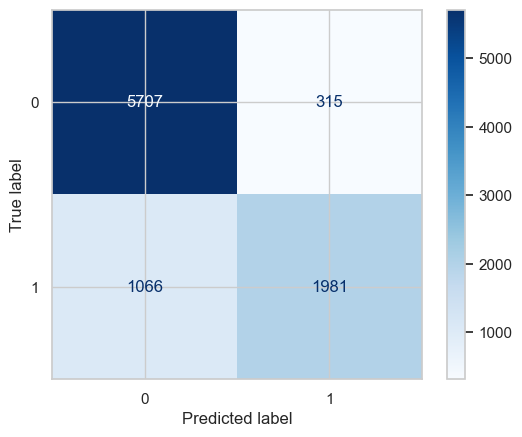

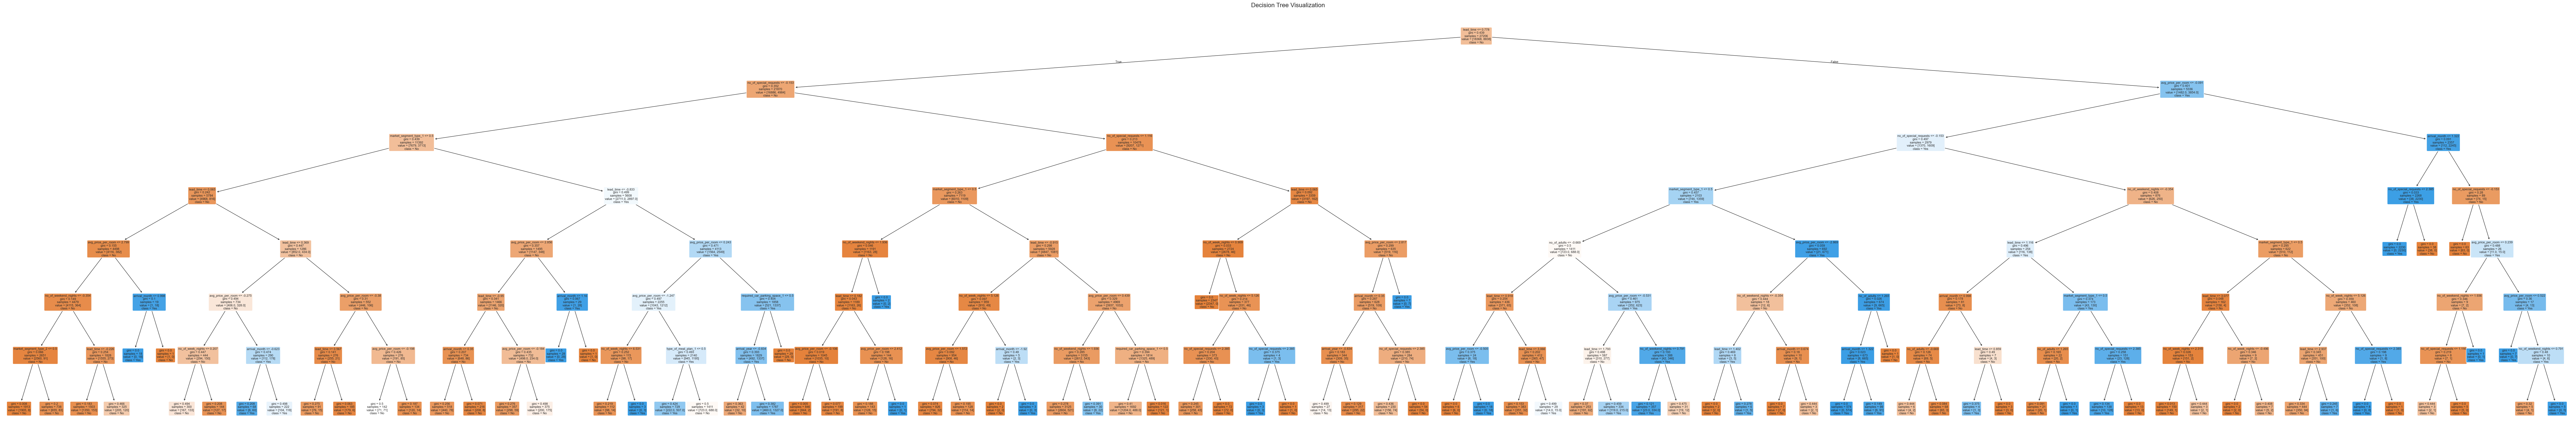

In [73]:
# Plot the decision tree
plt.figure(figsize=(120,20)) 
plot_tree(classifier, 
          filled=True,  
          feature_names=X_train_transformed.columns, 
          class_names=['No', 'Yes'],  
          rounded=True, 
          fontsize=8) 
plt.title('Decision Tree Visualization', fontsize=16) 
plt.show()

### Random Forest Classifier

In [75]:
# Instantiate the random forest classifier
rf_classifier = RandomForestClassifier(criterion='entropy', random_state=28, n_jobs=-1)
rf_classifier.fit(X_train_transformed, y_train)

# Make predictions for train and test data
y_pred_train = rf_classifier.predict(X_train_transformed)
y_pred_test = rf_classifier.predict(X_test_transformed)

# Evaluate performance for train set
acc_train = accuracy_score(y_train, y_pred_train) * 100
prec_train = precision_score(y_train, y_pred_train) * 100
recall_train = recall_score(y_train, y_pred_train) * 100
f1_train = f1_score(y_train, y_pred_train) * 100
false_positive_rate, true_positive_rate, _ = roc_curve(y_train, y_pred_train)
roc_auc_train = auc(false_positive_rate, true_positive_rate)

print(f"Train Accuracy: {acc_train}%")
print(f"Train Precision: {prec_train}%")
print(f"Train Recall: {recall_train}%")
print(f"Train F1 Score: {f1_train}%")
print(f"Train AUC: {roc_auc_train}")

Train Accuracy: 99.33838123943248%
Train Precision: 99.24914675767918%
Train Recall: 98.7101154107264%
Train F1 Score: 98.9788972089857%
Train AUC: 0.9917539742661755


In [76]:
# Evaluate performance for test set
acc_test = accuracy_score(y_test, y_pred_test) * 100
prec_test = precision_score(y_test, y_pred_test) * 100
recall_test = recall_score(y_test, y_pred_test) * 100
f1_test = f1_score(y_test, y_pred_test) * 100
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred_test)
roc_auc_test = auc(false_positive_rate, true_positive_rate)

print(f"Test Accuracy: {acc_test}%")
print(f"Test Precision: {prec_test}%")
print(f"Test Recall: {recall_test}%")
print(f"Test F1 Score: {f1_test}%")
print(f"Test AUC: {roc_auc_test}")

Test Accuracy: 90.230455397508%
Test Precision: 88.63067572399%
Test Recall: 81.3587134886774%
Test F1 Score: 84.83915126625598%
Test AUC: 0.8803903791338552


In [77]:
# Plot confusion matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)
cm_disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=rf_classifier.classes_)
# set color to green
cm_disp_test.plot(cmap=plt.cm.Greens)

Now, we'll plot a graph of the features ranked in order of importance. The top 4 features are:

1. Lead Time
2. Reservation Booked Online (market_segment_type_1)
3. Average Price Per Room
4. Number of Special Requests

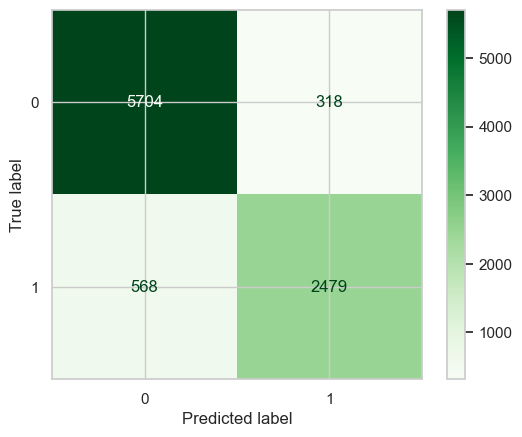

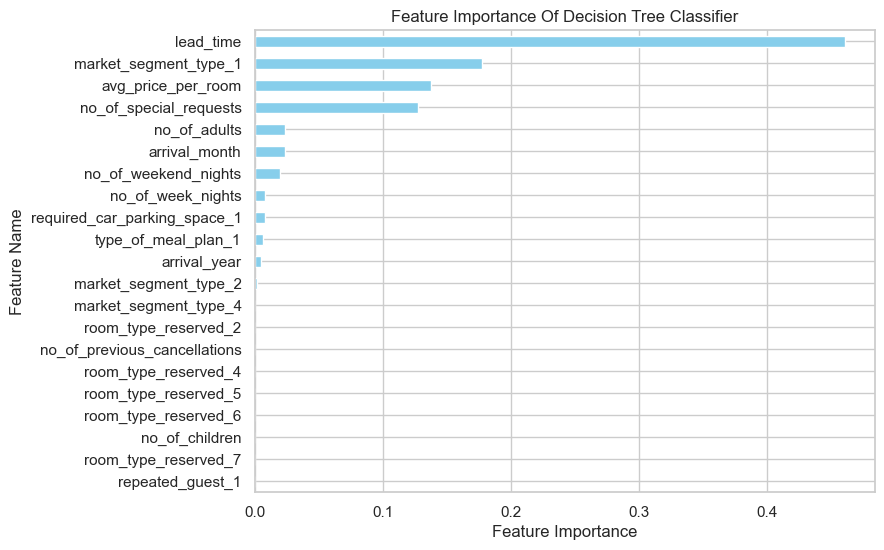

In [79]:
# Create bar chart with feature importance in descending order
feat_importance = pd.DataFrame(classifier.feature_importances_, index=X_train_transformed.columns, columns=["Importance"])
feat_importance.sort_values(by='Importance', ascending=True, inplace=True)
feat_importance.plot(kind='barh', figsize=(8,6), color='skyblue', legend=False)
plt.title('Feature Importance Of Decision Tree Classifier')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

## Recommendations

|         | Logistic  | Decision Tree |Random Forest|
|---------|-----------|---------------|-------------|
|Accuracy |   80.4%   |     84.8%     |     90.2%   |
|Precision|   74.7%   |     86.3%     |     88.6%   |
|Recall   |   63%     |     65%       |     81.4%   |
|F1 score |   68.4%   |     74.2%     |     84.8%   |
|AUC      |   0.76    |     0.8       |     0.88    |

- To predict hotel booking cancellations, we'll chose the ***Random Forest Classifier*** as the final model. This model offers a good balance between complexity and performance, achieving a precision score of ***89%***, which is a significant improvement over the ***Logistic Regression(74.7%)*** and ***Decision Tree models(86.3%)***.

### Key Insights

- The biggest factor leading to cancellations is `lead time`. This feature, which represents the number of days between the booking date and the arrival date, should be closely monitored by hotel management. Longer lead times generally increase the likelihood of cancellations, as customers might change their plans over time. Adjusting cancellation policies or offering incentives for early confirmations could help mitigate this risk.

- **Dynamic Pricing Strategy**: Implement a dynamic pricing model that adjusts room rates based on cancellation likelihood, especially for bookings with longer lead times.

- **Flexible Rebooking Options**: Offer flexible rebooking options to reduce outright cancellations, allowing customers to change their stay dates without penalties.

- **Monitor Customer Segments**: Different market segments have varying cancellation behaviors. Tailoring strategies to each segment can help in reducing cancellations.

- **Customer Communication**: Enhance communication strategies by sending reminders or personalized messages close to the stay date to reduce last-minute cancellations.

- **Loyalty Programs**: Encourage guests to enroll in loyalty programs, offering incentives for booking retention, such as discounts or rewards for completed stays.

- **Automated Alerts for High-Risk Bookings**: Implement a system that flags high-risk bookings (e.g., those with long lead times or multiple changes) for follow-up, such as sending reminders or personalized offers.

### Limitations

1. **Precision Score**:

    Although the precision score of 89% is significantly better than the baseline model's 74.7%, there is still a risk of false positives, where a booking is predicted to cancel but does not. This could lead to the hotel holding back rooms unnecessarily.

2. **Data Recency**:

    The dataset used for this analysis is from 2017-2018, which may not fully capture recent trends or changes in customer behavior, especially post-pandemic.

3. **Model Generalization**:

    While the model performs well on the test data, it may not generalize as effectively to different hotels or regions without additional tuning and validation.

### Future Work

1. **Model Enhancement**:

    Experiment with other machine learning models, such as KNN classifiers or Gradient Boosting Machines, to see if they offer improvements in precision and overall accuracy.

2. **Data Updates**:

    Use more recent data to ensure that the model captures current booking behaviors and external factors that may influence cancellations.

3. **Threshold Optimization**:

    Adjust the decision threshold to balance between precision and recall, depending on the hotel's specific business needs.

4. **Policy Adjustment**:

    Use insights from the model to inform cancellation policies, such as stricter policies for bookings with long lead times, or offering non-refundable options at a discount for bookings made closer to the arrival date.

5. **Additional Features**: 

    Incorporate additional features like weather information and social reputation.
